In [1]:
import time
from functools import partial

import elfi
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from elfi.examples.gauss import gauss, ss_mean, ss_var, euclidean_multidim

import logging
logging.basicConfig(level=logging.INFO)  # sometimes this is required to enable logging inside Jupyter

%matplotlib inline
%precision 2

# Set an arbitrary seed and a global random state to keep the randomly generated quantities the same between runs
seed = 20180620
np.random.seed(seed)
N = 1000

### Plotting Gauss

In [2]:
def gauss_nd_mean(*mu, cov_matrix, n_obs=15, batch_size=1, random_state=None):
    """Sample an n-D Gaussian distribution.

    Parameters
    ----------
    *mu : array_like
        Mean parameters.
    cov_matrix : array_like
        Covariance matrix.
    n_obs : int, optional
    batch_size : int, optional
    random_state : np.random.RandomState, optional

    Returns
    -------
    array_like
        n-D observations.

    """
    n_dim = len(mu)

    # Transforming the arrays' shape to be compatible with batching.
    batches_mu = np.zeros(shape=(batch_size, n_dim))
    for idx_dim, param_mu in enumerate(mu):
        batches_mu[:, idx_dim] = param_mu

    # Sampling the observations.
    y_obs = np.zeros(shape=(batch_size, n_obs, n_dim))
    for idx_batch in range(batch_size):
        y_batch = ss.multivariate_normal.rvs(mean=batches_mu[idx_batch], cov=cov_matrix,
                                             size=n_obs, random_state=random_state)
        if n_dim == 1:
            y_batch = y_batch[:, np.newaxis]
        y_obs[idx_batch, :, :] = y_batch
    return y_obs

In [3]:
def get_model(n_obs=50, true_params=None, seed_obs=None, nd_mean=False, cov_matrix=None):
    """Return a Gaussian noise model.

    Parameters
    ----------
    n_obs : int, optional
    true_params : list, optional
        Default parameter settings.
    seed_obs : int, optional
        Seed for the observed data generation.
    nd_mean : bool, optional
        Option to use an n-D mean Gaussian noise model.
    cov_matrix : array_like, optional
        Covariance matrix, a requirement for the nd_mean model.

    Returns
    -------
    elfi.ElfiModel

    """
    # Defining the default settings.
    if true_params is None:
        if nd_mean:
            true_params = [4, 4]  # 2-D mean.
        else:
            true_params = [4, .4]  # mean and standard deviation.

    # Choosing the simulator for both observations and simulations.
    if nd_mean:
        fn_simulator = partial(gauss_nd_mean, cov_matrix=cov_matrix, n_obs=n_obs)
    else:
        fn_simulator = partial(gauss, n_obs=n_obs)


    # Obtaining the observations.
    y_obs = fn_simulator(*true_params, n_obs=n_obs, random_state=np.random.RandomState(seed_obs))
    print('This is observations')
    print(y_obs)
    print('\n')

    m = elfi.new_model()
    # Initialising the priors.
    eps_prior = 5  # The longest distance from the median of an initialised prior's distribution.
    priors = []
    if nd_mean:
        n_dim = len(true_params)
        for i in range(n_dim):
            name_prior = 'mu_{}'.format(i)
            prior_mu = elfi.Prior('uniform', true_params[i] - eps_prior,
                                  2 * eps_prior, model=m, name=name_prior)
            priors.append(prior_mu)
    else:
        priors.append(elfi.Prior('uniform', true_params[0] - eps_prior,
                                 2 * eps_prior, model=m, name='mu'))
        priors.append(elfi.Prior('truncnorm', np.amax([.01, true_params[1] - eps_prior]),
                                 2 * eps_prior, model=m, name='sigma'))
    elfi.Simulator(fn_simulator, *priors, observed=y_obs, name='gauss')

    # Initialising the summary statistics.
    sumstats = []
    sumstats.append(elfi.Summary(ss_mean, m['gauss'], name='ss_mean'))
    sumstats.append(elfi.Summary(ss_var, m['gauss'], name='ss_var'))

    # Choosing the discrepancy metric.
    if nd_mean:
        elfi.Discrepancy(euclidean_multidim, *sumstats, name='d')
    else:
        elfi.Distance('euclidean', *sumstats, name='d')
    return m

### Plotting 1-d Gaussian noise model

In [4]:
true_mu_1d = [4]
cov_matrix_1d = [1]

In [5]:
m_1d = get_model(true_params=true_mu_1d, nd_mean=True, cov_matrix=cov_matrix_1d, seed_obs=seed)

This is observations
[[[4.88]
  [4.16]
  [4.65]
  [3.25]
  [4.42]
  [3.79]
  [2.38]
  [4.24]
  [3.57]
  [2.68]
  [3.85]
  [1.68]
  [5.53]
  [3.95]
  [2.49]
  [4.17]
  [4.8 ]
  [3.69]
  [3.41]
  [2.55]
  [4.1 ]
  [2.3 ]
  [5.45]
  [2.07]
  [4.18]
  [3.97]
  [3.98]
  [4.56]
  [3.64]
  [4.88]
  [4.38]
  [2.56]
  [2.96]
  [4.3 ]
  [5.23]
  [5.62]
  [5.98]
  [3.87]
  [4.22]
  [3.61]
  [2.27]
  [4.2 ]
  [3.62]
  [5.1 ]
  [4.04]
  [4.16]
  [4.36]
  [4.22]
  [4.22]
  [4.63]]]




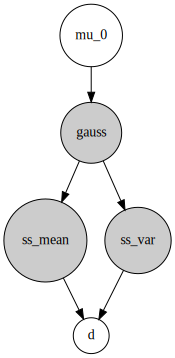

In [6]:
elfi.draw(m_1d['d'])

In [7]:
rej_1d = elfi.Rejection(m_1d['d'], batch_size=N, seed=seed)

In [8]:
result_1d = rej_1d.sample(N)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9c6400ba8>],
      dtype=object)

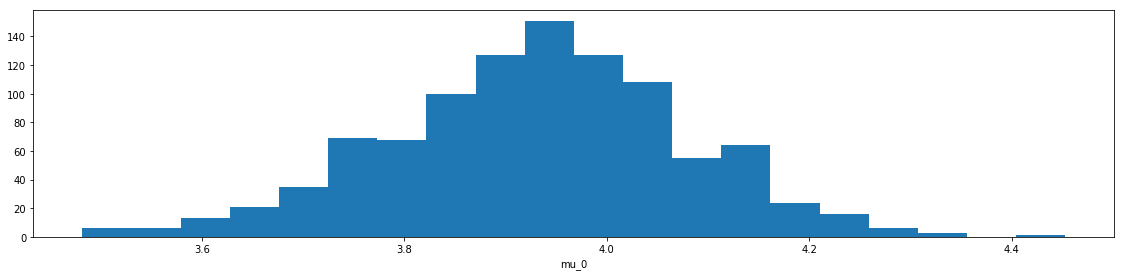

In [9]:
result_1d.plot_marginals()

IndexError: too many indices for array

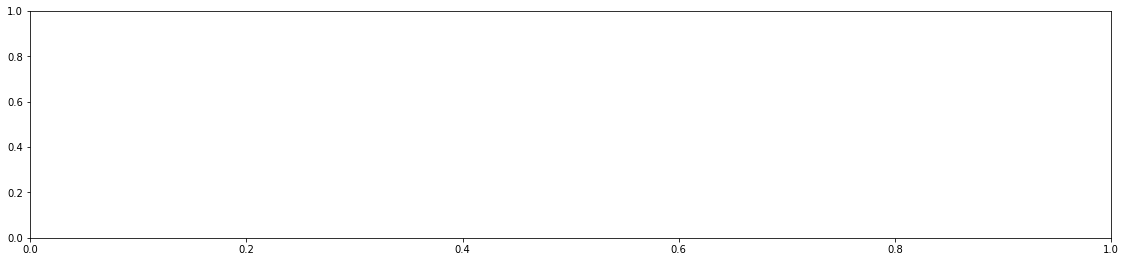

In [10]:
result_1d.plot_pairs()

### Plotting 2-D Gaussian model

In [11]:
true_mu_2d = [2, 3]
cov_matrix_2d = [3, 4]

In [12]:
m_2d = get_model(true_params=true_mu_2d, nd_mean=True, cov_matrix=cov_matrix_2d, seed_obs=seed)

This is observations
[[[ 2.28  4.75]
  [ 0.71  4.3 ]
  [ 1.64  3.84]
  [ 2.42 -0.25]
  [-0.29  2.14]
  [-2.02  2.7 ]
  [ 1.91  6.06]
  [ 2.3  -0.01]
  [ 1.47  4.59]
  [-0.51  1.82]
  [-0.95  3.2 ]
  [-1.34  5.9 ]
  [ 1.95  3.36]
  [ 2.98  2.95]
  [ 3.52  2.28]
  [-0.49  3.77]
  [ 2.52  0.92]
  [ 4.81  5.45]
  [ 1.78  6.95]
  [ 1.32  3.45]
  [ 2.35 -0.47]
  [ 3.91  2.24]
  [ 2.28  3.08]
  [ 2.38  3.72]
  [ 3.09  3.44]
  [-0.78  3.48]
  [ 1.67  4.54]
  [ 2.82  2.69]
  [ 2.29  2.07]
  [-1.33  1.93]
  [-0.39  2.74]
  [ 0.16  4.19]
  [ 2.43  3.67]
  [ 2.8   2.5 ]
  [ 3.63  3.54]
  [ 2.91  3.24]
  [-2.77  4.65]
  [ 2.82  2.98]
  [ 1.65  9.75]
  [ 4.07  0.74]
  [ 1.16  3.06]
  [ 2.34  3.3 ]
  [ 2.5   3.42]
  [ 3.97  3.5 ]
  [ 1.72  4.36]
  [ 4.51  3.93]
  [ 2.34  5.43]
  [ 0.85  6.55]
  [ 2.52 -1.21]
  [ 3.18  2.69]]]




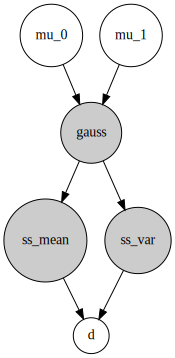

In [13]:
elfi.draw(m_2d['d'])

In [14]:
rej_2d = elfi.Rejection(m_2d['d'], batch_size=N, seed=seed)

In [15]:
result_2d = rej_2d.sample(N)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9e85a41d0>,
      dtype=object)

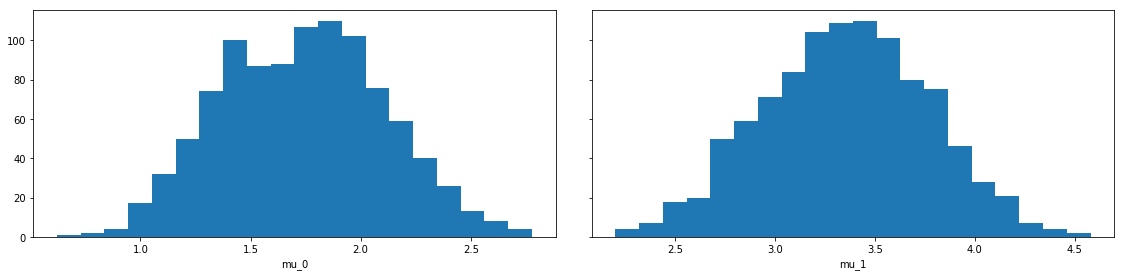

In [16]:
result_2d.plot_marginals()

In [ ]:
result_2d.plot_pairs()

### Plotting 3-D Gaussian model

In [ ]:
true_mu_3d = [2, 5, 6]
cov_matrix_3d = [3, 4, 7]

In [ ]:
m_3d = get_model(true_params=true_mu_3d, nd_mean=True, cov_matrix=cov_matrix_3d, seed_obs=seed)

In [ ]:
elfi.draw(m_3d['d'])

In [ ]:
rej_3d = elfi.Rejection(m_3d['d'], batch_size=N, seed=seed)

In [ ]:
result_3d = rej_3d.sample(N)

In [ ]:
result_3d.plot_marginals()

In [ ]:
result_3d.plot_pairs()

### Plotting 4-D Gaussian model

In [ ]:
true_mu_4d = [2, 4, 6, 8]
cov_matrix_4d = [1,3,5,7]

In [ ]:
m_4d = get_model(true_params=true_mu_4d, nd_mean=True, cov_matrix=cov_matrix_4d, seed_obs=seed)

In [ ]:
elfi.draw(m_4d['d'])

In [ ]:
rej_4d = elfi.Rejection(m_4d['d'], batch_size=N, seed=seed)

In [ ]:
result_4d = rej_4d.sample(N)

In [ ]:
result_4d.plot_marginals()

In [ ]:
result_4d.plot_pairs()